# Aim

General testing for sysid modifications.

In [1]:
# imports

import numpy as np
from scipy import optimize, signal, interpolate, stats
import matplotlib.pyplot as plt
import copy
import itertools
%matplotlib inline

# global parameter definitions

f_sampling = 1000 # Hz
f_1 = f_sampling/60 # lowest possible frequency of a vibration mode
f_2 = f_sampling/3 # highest possible frequency of a vibration mode
f_w = f_sampling/3 # frequency above which measurement noise dominates
N_vib_app = 2 # number of vibration modes being applied
N_vib_max = 2 # number of vibration modes to be detected
energy_cutoff = 1e-8 # proportion of total energy after which PSD curve fit ends
measurement_noise = 0.15 # milliarcseconds; pulled from previous notebook
time_id = 1 # timescale over which sysid runs. Pulled from Meimon 2010's suggested 1 Hz sysid frequency.
times = np.arange(0, time_id, 1/f_sampling) # array of times to operate on

Hypotheses to check:
    
1. _A parameter fit would still be inaccurate if it were operating on clean data instead of noisy data, because of something to do with MLE._  
If true: look for other parameter-fitting methods.   
If false: look at better denoising.  
2. _Time-domain fitting is more accurate than frequency-domain fitting, especially in determining amplitude and phase, which tend to be inaccurate in the PSD._ 
If true: you could Kalman filter for the parameters. Consider time-domain and frequency-domain fitting to be two dynamic processes whose parameters change slowly, and EKF considering one of them to be the 'true' dynamic system and the output of the other to be the measurements. This has the advantage of not having to re-run system ID: the system parameters dynamically update along with the process. This also fixes the sampling problem, in which frequencies can only have integral values because you're sampling one second of time data at 1000 Hz; if you're online for indefinite time rather than just one second, you have infinitely good resolution as time goes on.   
Alternatively, you could have continuously-online identification processes in one of the two domains, instead of finding both.
3. _Other than denoising, there's nothing specific about the PSD; you could do the same time-domain filtering with a regular FFT._  
This is the easiest one to check, but likely the least useful if it does work.

In [2]:
'''All the function definitions in one big cell! Soon this stuff will all get its own .py file where it makes sense
for it to all be together. For now this looks ugly but everything has to be updated all at once to avoid side effects.'''

# step 1: making vibration and atmospheric turbulence data 

def make_vibe_data():
    # takes in nothing (params are globally set in the 'global parameter definitions' cell)
    # returns a 1D np array with the same dimension as times.
    # note that we don't have access to the random parameters, just the output.
    vib_freqs    = np.round(np.random.uniform(low=f_1, high=f_2, size=N_vib_app))  # Hz
    vib_amps     = np.random.uniform(low=0.1, high=1, size=N_vib_app) # milliarcseconds
    vib_phase   = np.random.uniform(low=0.0, high=2*np.pi, size=N_vib_app)  # radians
    vib_damping  = np.random.uniform(low=1e-5, high=1e-3, size=N_vib_app) # unitless
    
    print("Amplitudes: ", vib_amps)
    print("Frequencies: ", vib_freqs)
    print("Damping coeffs: ", vib_damping)
    print("Phases: ", vib_phase)

    pos = sum([vib_amps[i]*np.sin(2*np.pi*vib_freqs[i]*times-vib_phase[i])
              *np.exp(-2*np.pi*vib_damping[i]*vib_freqs[i]*times) for i in range(N_vib_app)])
        
    return pos

def make_noisy_data(pos):
    return pos + np.random.normal(0, measurement_noise, np.size(times))

def make_atm_data():
    # takes in nothing (params are globally set in the 'global parameter definitions' cell)
    # returns a 1D np array with the same dimension as times
    # to be changed, clearly
    return np.zeros(times.size)

# step 2: find PSD

def get_psd(pos_noisy):
    # takes in noisy positions with time axis equal to the globally defined time axis
    # returns the frequency axis for a PSD, and the PSD.
    freqs, psd = signal.periodogram(pos_noisy, f_sampling)
    '''plt.semilogy(freqs, psd)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power spectrum ($mas^2$/Hz)")
    plt.ylim(1e-7, 1)
    plt.title("Noisy PSD")
    plt.show()'''
    return freqs, psd

# step 3: filter out measurement noise

def noise_filter(freqs, psd):
    # takes in the frequency axis for a PSD, and the PSD.
    # returns a cleaned PSD with measurement noise hopefully removed.
    ind = np.argmax(freqs > f_w)
    assert ind != 0, "didn't find a high enough frequency"
    avg_measurement_power = np.mean(psd[ind:])
    measurement_noise_recovered = np.sqrt(f_sampling * avg_measurement_power)
    #print("Recovered measurement noise: " + str(measurement_noise_recovered))
    #print("Percent error in measurement noise estimate: " 
    #      + str(100 * np.abs(measurement_noise_recovered - measurement_noise)/measurement_noise))

    psd -= avg_measurement_power

    # this subtraction is problematic because it goes negative, so quick correction here. 
    # Want a better way of doing this.

    for i, p in enumerate(psd):
        if p < 0:
            psd[i] = energy_cutoff

    # squelch: removing noise by applying a smoothing filter (convolution with [0.05, 0.1, 0.7, 0.1, 0.05])
    conv_peak = 0.7
    assert conv_peak < 1, "convolution must have unit gain"
    side = 1 - conv_peak
    kernel = np.array([side/6, side/3, conv_peak, side/3, side/6])
    c = kernel.size//2
    psd = np.convolve(psd, kernel)[c:-c]

    # ad hoc low-pass filter
    ind_cutoff = np.argmax(freqs > f_2)
    psd[ind_cutoff:] = energy_cutoff * np.ones(len(psd) - ind_cutoff) # or all zero?

    # and also a high-pass filter
    ind_cutoff = np.argmin(freqs < f_1)
    psd[:ind_cutoff] = energy_cutoff * np.ones(ind_cutoff)

    # bring the peaks back to where they were
    peak_ind = signal.find_peaks(psd, height=energy_cutoff)[0]
    for i in peak_ind:
        psd[i] = psd[i]/conv_peak
        
    '''plt.semilogy(freqs, psd)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power spectrum ($mas^2$/Hz)")
    plt.ylim(1e-7, 1)
    plt.title("Recovered PSD")
    plt.show()'''
    return psd

# step 4: find atmospheric fit parameters.

def atmosphere_fit(freqs, psd):
    # takes in the frequency axis for a PSD, and the PSD.
    # returns the residual PSD, and a 3x1 np array with fit parameters [k, f, sigma**2]
    # to be changed
    return psd, np.array([0, 0, 0])

# step 5: find vibe fit parameters

def damped_harmonic(pars_model):
    A, f, k, p = pars_model
    return A * np.exp(-k*2*np.pi*f*times) * np.sin(2*np.pi*f*times - p)

def damped_derivative(pars_model):
    # utility: returns derivative of damped_harmonic evaluated at time 0
    A, f, k, p = pars_model
    return A *2*np.pi*f * (k * np.sin(p) + np.cos(p))

def make_psd(pars_model):
    return signal.periodogram(damped_harmonic(pars_model), fs=f_sampling)[1]

def log_likelihood(func, data):
    def get_ll(pars):
        pars_model, sd = pars[:-1], pars[-1]
        data_predicted = func(pars_model)
        LL = -np.sum(stats.norm.logpdf(data, loc=data_predicted, scale=sd))
        return LL
    return get_ll

def psd_f(f):
    def get_psd_f(pars):
        A, k, p = pars
        return make_psd([A, f, k, p])
    return get_psd_f

def vibe_fit_time(pos):
    # takes in noisy positions
    # returns a 4xN np array with fit parameters, and a 1xN np array with variances.
    par0 = [0.5, (f_1 + f_2)/2, 1e-4, np.pi, 0.2]
    PARAMS_SIZE = len(par0) - 1

    params = np.zeros((N_vib_max, PARAMS_SIZE))
    variances = np.zeros(N_vib_max)

    posc = copy.deepcopy(pos)
    i = 0
    while i < N_vib_max and np.mean(posc**2) / np.mean(pos**2) > energy_cutoff:
        time_ll = log_likelihood(damped_harmonic, posc)
        A, f, k, p, sd = optimize.minimize(time_ll, par0, method='Nelder-Mead').x
        params[i] = [A, f, k, p]
        variances[i] = sd**2
        posc -= damped_harmonic(params[i])
        i += 1
    
    return params, variances
    

def vibe_fit_freq(freqs, psd):
    # takes in the frequency axis for a PSD, and the PSD.
    # returns a 4xN np array with fit parameters, and a 1xN np array with variances.
    par0 = [0.5, 1e-4, np.pi, 0.2]
    PARAMS_SIZE = len(par0) # slightly misleading: std is in par0 and frequency isn't so it matches up.

    # peak detection by correlation
    indshift = int(5*time_id) # index shift rescaling a freq shift of 5 Hz due to ID time; 
    # number of samples goes up because more time
    reference_peak = psd_f(250)(par0[:-1])
    center = np.argmax(reference_peak)
    reference_peak = reference_peak[center-indshift:center+indshift] 
    # any random peak should do; should be independent of the data though.

    peaks = []
    psd_windowed = copy.deepcopy(psd)
    for i in range(N_vib_max):
        peak = np.argmax(np.correlate(psd_windowed, reference_peak, 'same'))
        if psd_windowed[peak] <= energy_cutoff: # skip 
            continue
        peaks.append(peak)
        psd_windowed[peak-indshift:peak+indshift] = energy_cutoff

    params = np.zeros((len(peaks), PARAMS_SIZE))
    variances = np.zeros(len(peaks))

    # curve-fit to each identified peak and find corresponding parameters
    # currently, the number of identified peaks is always the maximum possible
    # since the idea of an 'applied vibration mode' exists only in simulation, this seems reasonable
    for i, peak_ind in enumerate(peaks):
        l, r = peak_ind - indshift, peak_ind + indshift
        windowed = psd[l:r]
        psd_ll = log_likelihood(lambda pars: psd_f(freqs[peak_ind])(pars)[l:r], windowed)
        A, k, p, sd = optimize.minimize(psd_ll, par0, method='Nelder-Mead').x
        params[i] = [A, freqs[peak_ind], k, p]
        variances[i] = sd**2
        
    return params, variances

# step 6: construct Q

def make_process_noise(variances):
    STATE_SIZE = 2*len(variances)
    Q = np.zeros((STATE_SIZE, STATE_SIZE))
    for i in range(variances.size):
        Q[2*i][2*i] = variances[i]
    return Q

# step 7: construct A

def make_state_transition(params):
    dt = 1/f_sampling
    STATE_SIZE = 2*params.shape[0]
    A = np.zeros((STATE_SIZE, STATE_SIZE))
    for i in range(STATE_SIZE//2):
        _, f, k, _ = params[i]
        w = 2*np.pi*f
        a = -w*k
        b = w * np.sqrt(1 - k**2)
        c, s = np.cos(b*dt), np.sin(b*dt)
        coeff = np.exp(a*dt)/b
        A[2*i][2*i] = coeff*(-a*s + b*c)
        A[2*i][2*i+1] = coeff*s
        A[2*i+1][2*i] = -coeff * w**2 * s
        A[2*i+1][2*i+1] = coeff * (a*s + b*c)
    return A

def make_measurement_matrix(STATE_SIZE):
    return np.array([[1, 0] * (STATE_SIZE//2)])

# step 8: simulate with no filtering and no control action

def simulate(params):
    A = make_state_transition(params)
    STATE_SIZE = 2*params.shape[0]
    state = np.array(list(itertools.chain.from_iterable([[
        damped_harmonic(params[i])[0], 
        damped_derivative(params[i])] 
        for i in range(STATE_SIZE//2)])))
    k = 0
    pos_r = np.zeros(int(f_sampling * time_id))
    H = make_measurement_matrix(STATE_SIZE)
    while k < time_id * f_sampling:
        pos_r[k] = H.dot(state)
        state = A.dot(state)
        k += 1
    return pos_r

# skipped step 9; unsure what it's doing.

# step 10: simulate filtering

def predict(A, P, Q, state):
    return (A.dot(state), A.dot(P.dot(A.T)) + Q)
    
def update(H, P, R, state, measurement):
        error = measurement - H.dot(state)
        K = P.dot(H.T.dot(np.linalg.inv(H.dot(P.dot(H.T)) + R)))
        return (state + K.dot(error), P - K.dot(H.dot(P)))

def kfilter(params, variances, measurements):
    # takes in parameters and variances from which to make a physics simulation
    # and measurements to match it against.
    A = make_state_transition(params)
    STATE_SIZE = 2*params.shape[0]
    state = np.array(list(itertools.chain.from_iterable([[
        damped_harmonic(params[i])[0], 
        damped_derivative(params[i])] 
        for i in range(STATE_SIZE//2)])))
    H = make_measurement_matrix(STATE_SIZE)
    Q = make_process_noise(variances)
    R = measurement_noise * np.identity(1)
    P = np.zeros((STATE_SIZE, STATE_SIZE))
    k = 0
    pos_r = np.zeros(int(f_sampling * time_id))
    while k < time_id * f_sampling:
        pos_r[k] = H.dot(state)
        state, P = predict(A, P, Q, state)
        state, P = update(H, P, R, state, measurements[k])
        k += 1
    return pos_r


In [3]:
# run everything

pos = make_vibe_data() + make_atm_data()
pos_noisy = pos + np.random.normal(0, measurement_noise, times.size)

Amplitudes:  [0.34930731 0.15224796]
Frequencies:  [256.  96.]
Damping coeffs:  [0.00068708 0.00035789]
Phases:  [1.39318403 0.98996733]


In [4]:
freqs, psd = get_psd(pos_noisy)
psd = noise_filter(freqs, psd)
params_f, variances_f = vibe_fit_freq(freqs, psd)
params_t, variances_t = vibe_fit_time(pos_noisy)
params = params_f
variances = variances_f
print(params_f)

[[ 5.51867070e-01  2.56000000e+02  1.54293100e-03 -7.42900117e+01]
 [ 1.52718219e-01  9.60000000e+01  2.70337241e-04  1.99304379e+00]]


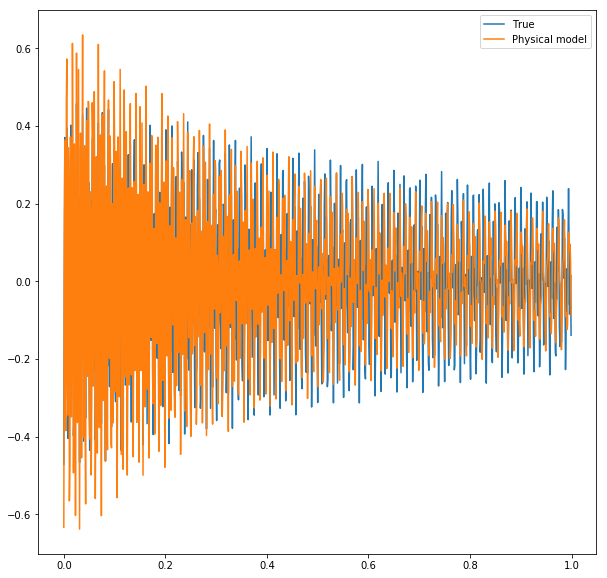

In [5]:
pos_r = simulate(params)
plt.figure(figsize=(10,10))
#plt.plot(times, pos_noisy, label='Measurements')
plt.plot(times, pos, label='True')
plt.plot(times, pos_r, label='Physical model')
#plt.plot(times, pos_r - pos, label='Residual')
plt.legend()

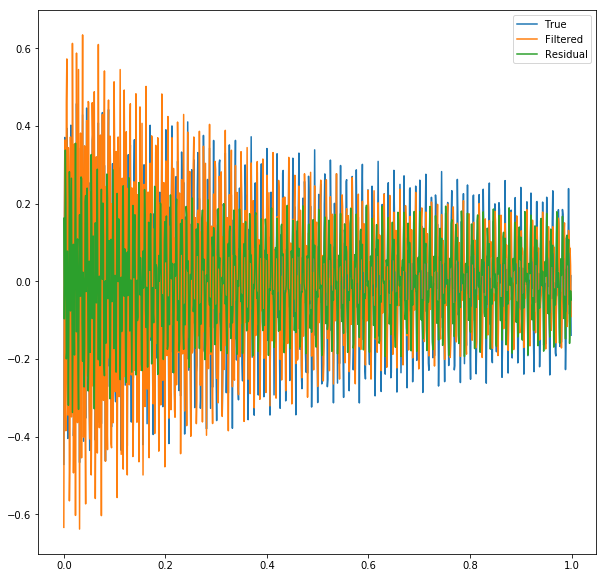

In [10]:
pos_k = kfilter(params, variances, pos_noisy)
plt.figure(figsize=(10,10))
#plt.plot(times, pos_noisy, label='Measurements')
plt.plot(times, pos, label='True')
plt.plot(times, pos_k, label='Filtered')
delay = 0
if delay >= 0:
    plt.plot(times[delay:], pos[:len(pos)-delay] - pos_k[delay:], label='Residual')
else:
    plt.plot(times[:len(times)+delay], pos[-delay:] - pos_k[:len(pos)+delay], label='Residual')
plt.legend()

Average measurement error: 0.12113889381049461
Average filter/obs. error: 0.09526875441255243


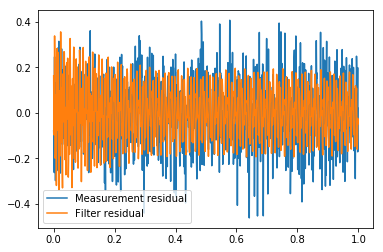

In [11]:
plt.figure(figsize=(6,4))
plt.plot(times, pos - pos_noisy, label='Measurement residual')
if delay >= 0:
    plt.plot(times[:len(times)-delay], pos[:len(pos)-delay] - pos_k[delay:], label='Filter residual')
else:
    plt.plot(times[:len(times)+delay], pos[-delay:] - pos_k[:len(pos)+delay], label='Residual')

plt.legend()

print("Average measurement error:", np.mean(np.abs(pos - pos_noisy)))
if delay >= 0:
    print("Average filter/obs. error:", np.mean(np.abs(pos[:len(pos)-delay] - pos_k[delay:])))
else:
    print("Average filter/obs. error:", np.mean(np.abs(pos[-delay:] - pos_k[:len(pos)+delay])))